READ ME
1. Hidden Layer

Hidden Layer is defind in the Class Hiddenlayer and can be used in the fit function.

2. ReLu function

Relu function is defined in the  Class Activation and can be used in the fit function.

3. Weight Decay and Momentum

They are defined in the Update function in Class MLP

4. Dropout

It is defined in the Dropout function in Class MLP including def Dropout and def dropout_forward

5. BN

It is defined in Class MLP including def Batchnorm_forward, Batchnorm_backward, batchnorm_forward, batchnorm_backward

6. Minibatch

It is in the Class MLP

7. Gelu

It is defined in the Class Activation 


How to use:

Just change the parameters in the nn.fit and try different pairs of Regularization methods

In [7]:
# import packages
from math import exp
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
from scipy.special import erf


In [8]:
!/opt/bin/nvidia-smi

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [9]:
x_train = np.load('train_data.npy')
x_test = np.load('test_data.npy')
y_train = np.load('train_label.npy')
y_test = np.load('test_label.npy')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
oh_y_train = np.zeros([len(y_train),10])
oh_y_test = np.zeros([len(y_test),10])

for i in range(len(y_train)):
    index = y_train[i][0]
    oh_y_train[i][index] = 1

for i in range(len(y_test)):
    index = y_test[i][0]
    oh_y_test[i][index] = 1

(50000, 128)
(50000, 1)
(10000, 128)
(10000, 1)


In [10]:
class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )

    # We add Relu activation 
    def __relu(self, x):

        '''
        lst = []
        for i in x:
            lst.append(max(0,i))
        return np.array(lst)
        '''

        lt = np.vstack([np.zeros(x.shape),x])
        return np.max(lt, axis = 0)



    
    def __relu_deriv(self, a):

        '''
        lst = []
        for i in a:
            if i <= 0:
                lst.append(0)
            elif i > 0:
                lst.append(1)
        return np.array(lst)
        '''

        ls = np.vstack([np.zeros(a.shape),a])
        lmax = np.max(ls, axis = 0)
        lt = np.vstack([np.ones(a.shape),lmax])

        return np.min(lt, axis = 0)

        
    
    # We add Gelu activation
    def __gelu(self, x):
        cdf = 0.5 * (1.0 + erf(x / np.sqrt(2.0)))
        return x * cdf

    def __gelu_derivative(self, x):
        cdf = 0.5 * (1.0 + erf(x / np.sqrt(2.0)))
        P_x = 1/np.sqrt(2.0*np.pi)*np.exp(-1/2*x**2)
        return cdf+x*P_x



    def __softmax(self, x):
        return np.exp(x)/sum(np.exp(x))   

    def __softmax_deriv(self, a, b):
        j = np.argwhere(b == 1)[0][0]
        w = a[j]
        a = -a[j]*a
        a[j] = w*(1-w)
        return a
                       
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == "relu":
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == "softmax":
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation == "gelu":
            self.f = self.__gelu
            self.f_deriv = self.__gelu_derivative


In [11]:
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # we randomly assign small values for the weights as the initiallization
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        if activation == 'logistic':
            self.W *= 4
            
        # relu initialization
        
        if activation == 'relu':
            self.W = np.random.uniform(
                low = -np.sqrt(6. /n_in),
                high = np.sqrt(6. /n_in),
                size = (n_in, n_out)
            )
        # gelu initialization
        if activation == 'gelu':
            self.W = np.random.uniform(
                low = -np.sqrt(6. /n_in),
                high = np.sqrt(6. /n_in),
                size = (n_in, n_out)
            )
        
        
        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)
        
        # we set he size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        self.v = np.zeros(self.grad_W.shape)
        self.n = np.zeros(self.grad_b.shape)
        
    
    # the forward and backward progress (in the hidden layer level) for each training epoch
    # please learn the week2 lec contents carefully to understand these codes. 
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output
    
    def backward(self, delta, output_layer=False):         
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = delta
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta
        

In [12]:
def accuracy(x_pred, y_test):
  correct = 0
  for i in range(len(x_pred)):
    if x_pred[i] == y_test[i]:
      correct += 1
  accuracy = correct/len(x_pred)
  return  accuracy

In [13]:
import math


class MLP:
    """
    """ 

    # for initiallization, the code will create all layers automatically based on the provided parameters.     
    def __init__(self, layers, activation=[None,'tanh','tanh'], batchnorm = (1,0,0), weight_decay = None, momentum = None, dropout = None, minibatch = None, ):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        
        self.activation=activation
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.v = None
        self.n = None
        self.dropout = dropout
        self.minibatch = minibatch


        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))

    def Dropout(self, x):
        keeprate = 1 - self.dropout
        drop_tensor = np.random.binomial(n=1, p=keeprate, size = x.shape)
        #print(drop_tensor)
        x *= drop_tensor
        #print(x)
        #x /= keeprate
        #print(x)
        return x, drop_tensor

    def Batchnorm_forward(self,input):
        #print(input.shape)
        N,D = input.shape      

        # calculate mean
        mean = 1./N * np.sum(input, axis = 0)
        xmean = input - mean

        # calculate variance
        var = 1./N * np.sum((xmean**2), axis = 0)

        # calculate factor
        sqrt_var = np.sqrt(var + self.eps)
        factor = 1./sqrt_var

        # x_norm
        x_norm = xmean * factor

        # Scaling and Shift
        out = self.gamma * x_norm + self.beta

        # Saving
        para = (x_norm, self.gamma, xmean, factor, sqrt_var, var, self.eps)
        

        return out, para

    def Batchnorm_backward(self, delta, para):
        x_norm, self.gamma, xmean, factor, sqrt_var, var, self.eps = para

        N,D = delta.shape
        

        back_beta = np.sum(delta, axis = 0)
        back_gamma = np.sum(delta*x_norm, axis = 0)
        back_xnorm = delta*self.gamma

        back_ivar = np.sum(back_xnorm*xmean, axis = 0)
        back_xmean1 = back_xnorm * factor

        back_sqrt_var = -1./(sqrt_var**2) * back_ivar

        back_var = 0.5 * 1./np.sqrt(var + self.eps) * back_sqrt_var

        back_sq = 1./N * np.ones((N,D)) * back_var

        back_xmean2 = 2 * xmean * back_sq

        back_x1 = (back_xmean1 + back_xmean2)
        back_xmean = -1 * np.sum(back_xmean1 + back_xmean2, axis = 0)

        back_x2 = 1./N * np.ones((N,D)) * back_xmean

        back_x = back_x1 + back_x2

        return back_x, back_gamma, back_beta


    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        return output

    def dropout_forward(self, input):
        drop_tensor_list = []
        for layer in self.layers[:len(self.layers)-1]:
            output=layer.forward(input)

            input=output
            input, drop_tensor=self.Dropout(input)

            drop_tensor_list.append(drop_tensor)
        output=self.layers[-1].forward(input)

        return output, drop_tensor_list


    def batchnorm_forward(self,input):
        para_dict = {}
        for layer in range(len(self.layers)):
            input, para=self.Batchnorm_forward(input)
            output=self.layers[layer].forward(input)
            input=output
            para_dict[layer] = para
        return output, para_dict




    # define the objection/loss function, we use mean sqaure error (MSE) as the loss
    # you can try other loss, such as cross entropy.
    # when you try to change the loss, you should also consider the backward formula for the new loss as well!

    def cross_entropy(self,y,y_hat):
        activation_deriv = Activation(self.activation[-1]).f_deriv
        j = np.argwhere(y == 1)[0][0]
        loss = -np.log(y_hat[j])

        # -(1/y_hat[j]) is the partial derivative of loss to the non-linear function
        delta = -(1/y_hat[j]) * activation_deriv(y_hat,y)
        return loss,delta

    # backward progress  
    def backward(self,delta,*dropout_tensor_list):
        delta=self.layers[-1].backward(delta,output_layer=True)

        if not dropout_tensor_list:
          for layer in reversed(self.layers[:-1]):
              delta=layer.backward(delta)

        else:
          index = -1
          for layer in reversed(self.layers[:-1]):
              delta = delta*dropout_tensor_list[-1][index]

              delta = layer.backward(delta)

              index -= 1
        
        grad_w = []
        grad_b = []
        for layer in self.layers:
          grad_w.append(layer.grad_W)
          grad_b.append(layer.grad_b)
        grad_w = np.array(grad_w)
        grad_b = np.array(grad_b)

        return grad_w, grad_b

    def batchnorm_backward(self,delta,para_dict):
        delta=self.layers[-1].backward(delta,output_layer=True)
        
        delta, self.gamma, self.delta = self.Batchnorm_backward(delta,para_dict[len(self.layers)-1])

        item = len(self.layers) - 2
        for layer in reversed(self.layers[:-1]):

            delta = layer.backward(delta)
            if item != 0:
                delta, self.gamma, self.delta = self.Batchnorm_backward(delta,para_dict[item])

                item -= 1



    # update the network weights after backward.
    # make sure you run the backward function before the update function! 

    def update(self,lr):
        if self.weight_decay == None:
            if self.momentum == None:
                for layer in self.layers:
                    layer.W -= lr * layer.grad_W
                    
                    layer.b -= lr * layer.grad_b
            else:
                if self.v == None:
                    self.v = {}
                    for layer in range(len(self.layers)):
                      self.v[layer] = self.layers[layer].v
                if self.n == None:
                    self.n = {}
                    for layer in range(len(self.layers)):
                      self.n[layer] = self.layers[layer].n  
 
                for layer in range(len(self.layers)):
                    self.v[layer] = (self.momentum * self.v[layer]) + (self.layers[layer].grad_W)
                    self.layers[layer].W -= lr * self.v[layer]
                    
                    self.n[layer] = (self.momentum * self.n[layer]) + (self.layers[layer].grad_b)
                    self.layers[layer].b -= lr * self.n[layer]

                
                
        # weight_decay
        else:
            if self.momentum == None:
                for layer in self.layers:    
                    layer.grad_W = layer.grad_W + self.weight_decay*layer.W
                    layer.W -= lr * layer.grad_W
                    
                    layer.b -= lr * layer.grad_b
            else:
                if self.v == None:
                    self.v = {}
                    for layer in range(len(self.layers)):
                      self.v[layer] = self.layers[layer].v
                if self.n == None:
                    self.n = {}
                    for layer in range(len(self.layers)):
                      self.n[layer] = self.layers[layer].n  
 
                for layer in range(len(self.layers)):
                    self.layers[layer].grad_W = self.layers[layer].grad_W + self.weight_decay * self.layers[layer].W
                    self.v[layer] = (self.momentum * self.v[layer]) + (self.layers[layer].grad_W)
                    self.layers[layer].W -= lr * self.v[layer]
                    
                    self.n[layer] = (self.momentum * self.n[layer]) + (self.layers[layer].grad_b)
                    self.layers[layer].b -= lr * self.n[layer]


    def miniupdate(self,lr,grad_globe_w,grad_globe_b):
      step = 0
      
      for layer in self.layers:
        layer.W -= lr * grad_globe_w[step]
        #print(layer.W)
        layer.b -= lr * grad_globe_b[step]
        step+=1

    # define the training function
    # it will return all losses within the whole training process.

    def random_mini_batches(self,X,Y,mini_batch_size=256,seed=47):
      
      np.random.seed(seed)
      m = X.shape[0]
      mini_batches = []
      
      # Generate a random order value of 0~m-1 as our subscript
      permutation = list(np.random.permutation(m))
      # Get the scrambled training set.
      shuffled_X = X[permutation,:]
      shuffled_Y = Y[permutation,:]

      
      # Get the total number of subsets, math.floor means rounding down.
      num_complete_minibatches = math.floor(m / mini_batch_size)


      for k in range(0,num_complete_minibatches):
        
          mini_batch_X = shuffled_X[k * mini_batch_size:(k+1) * mini_batch_size ]
          mini_batch_Y = shuffled_Y[k * mini_batch_size:(k+1) * mini_batch_size ]

          mini_batch = (mini_batch_X, mini_batch_Y)
          mini_batches.append(mini_batch)
        #It means that there is still less than one batch size left, and the rest is regarded as one batch.
      if m % mini_batch_size != 0:
          mini_batch_X = shuffled_X[mini_batch_size * num_complete_minibatches:]
          mini_batch_Y = shuffled_Y[mini_batch_size * num_complete_minibatches:]

          mini_batch = (mini_batch_X, mini_batch_Y)
          mini_batches.append(mini_batch)

      return mini_batches






    def fit(self,X,y,x_test,y_test,learning_rate=0.1, epochs=100):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        
        y=np.array(y)
        
        to_return = np.zeros(epochs)

        acc_list = []
        
        if self.minibatch != None:
          seed = 0
          
          for i in range(epochs):
            
            seed = seed + 1
            
            minibatches = self.random_mini_batches(X,y)
            loss_list = []
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                
                loss = np.zeros(minibatch_X.shape[0])
                grad_globe_w = np.zeros(len(self.layers))
                grad_globe_b = np.zeros(len(self.layers))
                for num in range(len(minibatch_X)):
                    if self.dropout != None:

                        y_hat, dropout_tensor_list = self.dropout_forward(minibatch_X[num])

                        loss[num], delta = self.cross_entropy(minibatch_Y[num], y_hat)

                        grad_w, grad_b = self.backward(delta, dropout_tensor_list)
                   
                    if self.dropout == None:

                        y_hat = self.forward(minibatch_X[num])

                        loss[num], delta = self.cross_entropy(minibatch_Y[num], y_hat)

                        grad_w, grad_b = self.backward(delta)
     

                    grad_globe_w=np.add(grad_globe_w, grad_w)
                    grad_globe_b=np.add(grad_globe_b, grad_b)

                  

                loss_list.append(loss)

               

                grad_globe_w = grad_globe_w/len(minibatch_X) 
                grad_globe_b = grad_globe_b/len(minibatch_X)
                  
                
                
                self.miniupdate(learning_rate,grad_globe_w,grad_globe_b)
            print('Current epoch is : ', i)


            loss_global_list = []
            
            for loss_local in loss_list:
              loss_global_list += list(loss_local)
            
            

            to_return[i] = np.mean(loss_global_list)
            if i % 2 == 0:
                Acc = self.predict(x_test)
                acc_list.append(accuracy(Acc,y_test))

        else:

          for k in range(epochs):
              loss=np.zeros(X.shape[0])
              for it in range(X.shape[0]):
                  i=np.random.randint(X.shape[0]) 
                  # forward pass
                  if self.dropout != None:
                    y_hat, dropout_tensor_list = self.dropout_forward(X[i])
                    
                    # backward pass
                    
                    loss[it], delta = self.cross_entropy(y[i],y_hat)
                    self.backward(delta, dropout_tensor_list)
                    y

                  if self.dropout == None:
                    # forward pass
                    y_hat = self.forward(X[i])
                    
                    # backward pass
                    
                    loss[it], delta = self.cross_entropy(y[i],y_hat)
                    self.backward(delta)
                    y
              
                  # update
                  self.update(learning_rate)
              to_return[k] = np.mean(loss)
              if k % 2 == 0:
                Acc = self.predict(x_test)
                acc_list.append(accuracy(Acc,y_test))
              # print(y_hat)
              print('Current epoch is : ', k)
        return to_return, acc_list

    # define the prediction function
    # we can use predict function to predict the results of new data, by using the well-trained network.
    def predict(self, x):
        x = np.array(x)
        output = np.zeros(x.shape[0]) 
        for i in np.arange(x.shape[0]):
            output[i] = list(self.forward(x[i,:])).index(max(self.forward(x[i,:])))
        return output

In [14]:
### Try different MLP models
## + minibatch 
## + minibatch+weight+momentum 
## + minibatch+weight+momentum+drop 
## + minibatch+weight+momentum+batch norm
## + minibatch+weight+momentum+drop+batch norm
nn = MLP([128,64,32,10], [None,'relu','relu','softmax'],minibatch = 256, weight_decay= 0.02, momentum=0.9, dropout = 0.5, batchnorm = (1,0,0) )
input_data = x_train
output_data = oh_y_train
#,weight_decay = 0.02, momentum = 0.9,dropout=0.5

In [15]:
### Try different learning rate and epochs
import time 
start = time.time()
CE,Accuracy = nn.fit(input_data, output_data,x_test,y_test,learning_rate=0.1, epochs=1)
end = time.time()
print('loss:%f'%CE[-1])
print('Running timr',(end-start)/60)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:169: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Current epoch is :  0
loss:2.279156
Running timr 0.2708534479141235


In [ ]:
Model2_CE = list(CE)
print(Model2_CE)
#print(Baseline_CE)

[2.0202910169939026, 1.7885153977325186, 1.7066822223618487, 1.652594860829045, 1.6102258283574509, 1.5754857318311033, 1.5460899832636432, 1.5209064109226327, 1.4990010371355695, 1.4798819604751787, 1.4627853892557519, 1.4475137265676141, 1.4337824439855569, 1.4213447622956188, 1.409956347129652, 1.3994039825206888, 1.3895043967121417, 1.3801745447961267, 1.3714234311255165, 1.36317517998264, 1.3553732427462277, 1.3480448526920579, 1.3411570326843698, 1.334730426891999, 1.328699353685288, 1.3229897076425945, 1.3175306884426885, 1.3123201060343217, 1.3073210627130756, 1.3025580472453093, 1.2979605185485368, 1.2935669955835145, 1.2893035840026248, 1.2851639435357265, 1.2811508333524135, 1.2772693593477216, 1.2735377143782398, 1.2699838205498142, 1.2665457009438374, 1.2632185420572521, 1.2599844875110628, 1.2568479352869084, 1.2538009905533938, 1.250840847912902, 1.2479769628595765, 1.2451962007866586, 1.2424728283504307, 1.2398177202126095, 1.2372277056685161, 1.2347070867741359, 1.2322

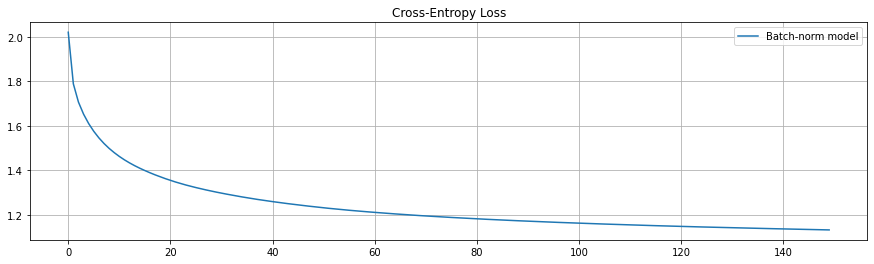

In [ ]:
pl.figure(figsize=(15,4))
pl.plot(CE,label='Batch-norm model')
pl.title('Cross-Entropy Loss')
pl.legend()
pl.grid()
pl.savefig('model2-CEloss.png')

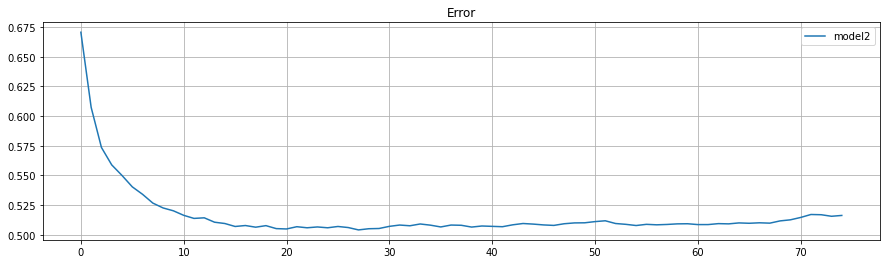

In [ ]:
pl.figure(figsize=(15,4))
pl.plot((1-np.array(Accuracy)),label='model2')
pl.title('Error')
pl.legend()
pl.grid()
pl.savefig('model2-Error.png')

In [ ]:
Model2_Error = list((1-np.array(Accuracy)))
print(Model2_Error)
#print(list((1-np.array(Accuracy))))

[0.6706, 0.6073, 0.5735, 0.5588, 0.5499, 0.5403, 0.534, 0.5266, 0.5225, 0.5201, 0.5163, 0.5137, 0.5142, 0.5105, 0.5094000000000001, 0.5069, 0.5077, 0.5063, 0.5076, 0.5051, 0.5048, 0.5066999999999999, 0.5058, 0.5065, 0.5058, 0.5069, 0.506, 0.504, 0.505, 0.5052, 0.507, 0.5081, 0.5075000000000001, 0.509, 0.508, 0.5065, 0.5081, 0.5079, 0.5064, 0.5073, 0.507, 0.5066999999999999, 0.5083, 0.5094000000000001, 0.5089, 0.5082, 0.5078, 0.5092, 0.5099, 0.51, 0.511, 0.5117, 0.5094000000000001, 0.5086999999999999, 0.5077, 0.5086999999999999, 0.5083, 0.5085999999999999, 0.5091, 0.5092, 0.5085, 0.5085, 0.5093, 0.5091, 0.5099, 0.5096, 0.51, 0.5097, 0.5116, 0.5125, 0.5145, 0.517, 0.5167999999999999, 0.5155000000000001, 0.5162]


In [ ]:
from sklearn.metrics import accuracy_score
Acc = nn.predict(x_test)
accuracy_score(Acc,y_test)

0.4828

In [ ]:
## 导出
with open("base_Error.txt", "w") as f:
  for i in Model2_Error:
    f.write(str(i)+"\n")
f.close()

with open("base_CE.txt", "w") as f:
  for i in Model2_CE:
    f.write(str(i)+"\n")
f.close()

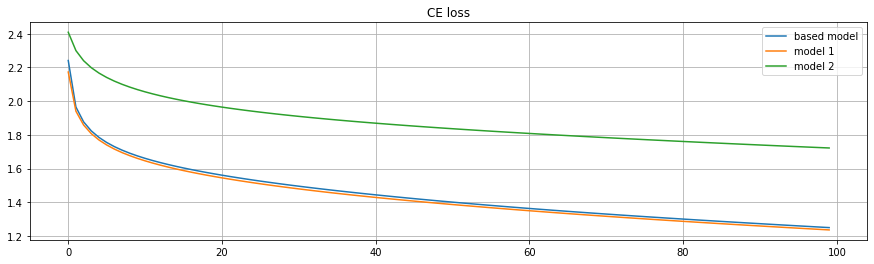

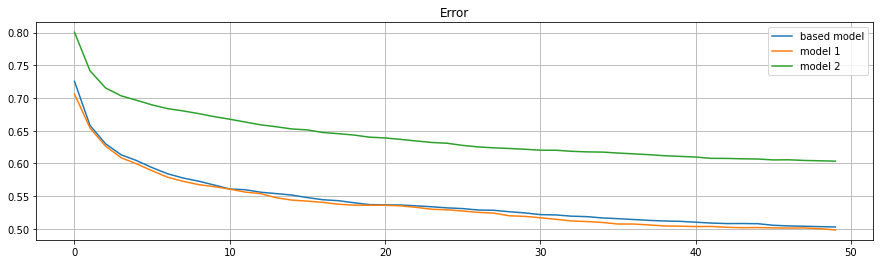

In [ ]:
# test

base_m = [2.241429879292183, 1.9652357132337368, 1.877020005107797, 1.823460788769523, 1.7849601257820253, 1.7549109590408127, 1.730276793162248, 1.7093661247531557, 1.6911980101824249, 1.6751025467770748, 1.6606110626921748, 1.64739476930592, 1.6352387730722306, 1.62397479843911, 1.6134433240792965, 1.603516491987746, 1.594140097160798, 1.5852119177282826, 1.5766945602586964, 1.5685365020617574, 1.5607060420105956, 1.5531793834421062, 1.545934160245722, 1.5389341913057144, 1.5321471059167537, 1.5255613535791657, 1.519175875872493, 1.5129558455875536, 1.5069043753600901, 1.5010158134098188, 1.495276413513315, 1.4896698541293365, 1.4841923995626596, 1.478831987630701, 1.473579006138387, 1.4684281354209507, 1.4633760059660559, 1.458408243943824, 1.453525239440958, 1.4487280050785634, 1.4440159550464409, 1.4393805332399585, 1.434816167963678, 1.4303252112159686, 1.425906647305821, 1.421554342965499, 1.4172716934887921, 1.4130536286302933, 1.40889035621892, 1.4047848391984223, 1.4007364857895364, 1.3967482549184205, 1.3928140518688883, 1.3889368290917128, 1.385111130894203, 1.3813388770661503, 1.3776120971365529, 1.373931607532732, 1.3702905960904792, 1.3666962350402012, 1.3631480464669965, 1.3596473618767124, 1.356188439264897, 1.3527730821736206, 1.3493999370343255, 1.346067776111009, 1.3427750906476605, 1.3395189156961078, 1.3363042492003288, 1.3331251903389028, 1.3299754021466215, 1.3268617947528127, 1.3237769186834836, 1.3207243202703178, 1.3177024606100936, 1.314713811760614, 1.3117588148336319, 1.308836854579558, 1.3059403028149685, 1.3030629488386798, 1.3002090730070235, 1.297379076864094, 1.2945718884570334, 1.2917897350077467, 1.2890331284178242, 1.2862946760434335, 1.2835725923100758, 1.2808630064462025, 1.2781705183701517, 1.2754903146586125, 1.2728252250611396, 1.270175765198342, 1.2675452148794366, 1.2649327824085603, 1.2623379422976744, 1.2597601323547138, 1.257198208813083, 1.2546490037422142, 1.2521146516998205, 1.2495930544848035]
m1_m = [2.173045576734361, 1.9402454139967504, 1.8584067525231487, 1.8071778443669884, 1.7696735098346703, 1.7401131389098574, 1.7156638596598006, 1.6948209654199964, 1.676621063572514, 1.6604416445545016, 1.6458374180001216, 1.6324776862741905, 1.62016311782203, 1.6087312974065486, 1.5980525177554072, 1.588012803348256, 1.5785208833122382, 1.5695116636178155, 1.5609265394227647, 1.5527141284483004, 1.5448430049643878, 1.5372836859753143, 1.5299987292829786, 1.5229604601313251, 1.5161520230756744, 1.5095547193027783, 1.5031568976474892, 1.4969509323716343, 1.4909157537403706, 1.4850400492237044, 1.479318431230761, 1.473739144469608, 1.4682861021104339, 1.4629499710210792, 1.4577301407475243, 1.4526258021458232, 1.4476316098132447, 1.4427423690062828, 1.4379542167229673, 1.433259664010666, 1.4286606775253223, 1.4241461372708137, 1.419713553335968, 1.4153520064733676, 1.4110580085052304, 1.4068337064979721, 1.4026695327078638, 1.3985550831665234, 1.394498436790344, 1.390498955499194, 1.3865475667204141, 1.38264726434747, 1.3788004869160337, 1.375007453672809, 1.3712633475505707, 1.3675674833077112, 1.3639136555274023, 1.3603002619943523, 1.35672751915413, 1.3531896929886218, 1.349689554017693, 1.3462293162490864, 1.3428038220511047, 1.339416990566028, 1.3360660593032916, 1.3327496839575024, 1.3294656445655617, 1.3262188811142286, 1.323005396032725, 1.3198213414197308, 1.3166682048554779, 1.3135500067047106, 1.3104601245507987, 1.3073998008346834, 1.3043706747331627, 1.301368380449641, 1.298393738735974, 1.2954483444884841, 1.292530592111633, 1.2896375676790959, 1.2867625866924004, 1.2839098656000079, 1.2810824288379352, 1.2782751790460793, 1.2754901748663952, 1.2727285054419517, 1.269985131935992, 1.2672561097142303, 1.26454240835091, 1.261845469914593, 1.2591667231859713, 1.2565073330510403, 1.2538669863814107, 1.251245665579527, 1.2486420850715958, 1.2460572674560344, 1.2434869955687602, 1.2409279029069726, 1.2383852261074344, 1.2358563635617354]
m2_m = [2.4091670197489528, 2.3001332526880387, 2.2401133590780575, 2.19857387218266, 2.166725278560438, 2.1408463515037863, 2.1190509150008268, 2.1001975900968186, 2.083583984484599, 2.0687513915446964, 2.055356193264972, 2.043139947819735, 2.0319223911655753, 2.021547014591542, 2.0118896508331536, 2.002856579438339, 1.99436649425365, 1.986365861102824, 1.978802176796897, 1.9716255990037181, 1.9647955848948215, 1.9582753786798304, 1.952039115333652, 1.9460589940380733, 1.9403158682748864, 1.9347916701256607, 1.9294627375633078, 1.924318238563564, 1.9193432294151793, 1.9145232052339485, 1.9098496780768979, 1.9053107554065634, 1.9008952085793132, 1.8966005126128302, 1.892420415802323, 1.888346205953037, 1.884368989838924, 1.8804824666258673, 1.876683920639679, 1.8729696488803713, 1.869333017920233, 1.8657678021199562, 1.862271536280957, 1.858842561568133, 1.8554762806322704, 1.852173311065295, 1.8489281135873255, 1.845738586719573, 1.8426034387770898, 1.839519734331786, 1.8364845589382979, 1.8334979235577047, 1.8305563484966303, 1.8276567363653349, 1.8247982160688143, 1.8219786360728667, 1.8191962415728338, 1.8164491303210104, 1.813736645732216, 1.8110564040075792, 1.8084090283226388, 1.805791840140369, 1.8032067395382814, 1.8006515141507533, 1.7981242726761137, 1.7956225993726944, 1.793146581840509, 1.7906956048199916, 1.7882680461945153, 1.7858648056174158, 1.7834860390691527, 1.7811305779765803, 1.7787974068714396, 1.7764858854360892, 1.7741942084120557, 1.7719238527066405, 1.7696726994596252, 1.767439281712749, 1.765223064023926, 1.7630242853460796, 1.760840428974886, 1.7586733931300649, 1.7565221393226154, 1.7543872663865736, 1.7522684257553256, 1.7501667662907507, 1.748080047520111, 1.7460087134070643, 1.7439546028077046, 1.7419153880480795, 1.739888567291238, 1.737877101062688, 1.7358805248039533, 1.7338956474123595, 1.7319214128609066, 1.7299587873927593, 1.7280066763447977, 1.7260658642666353, 1.7241351322440417, 1.7222147814418882]


pl.figure(figsize=(15,4))
pl.plot(base_m,label='based model')
pl.plot(m1_m,label='model 1')
pl.plot(m2_m,label='model 2')
pl.title('CE loss')
pl.legend()
pl.grid()

error_based = [0.7254, 0.6578999999999999, 0.63, 0.6132, 0.6043000000000001, 0.5935, 0.5841000000000001, 0.5776, 0.5728, 0.5669, 0.5609, 0.5597, 0.5559000000000001, 0.5538000000000001, 0.5516, 0.5477000000000001, 0.5444, 0.5429999999999999, 0.5398000000000001, 0.5369999999999999, 0.5366, 0.5364, 0.5351, 0.5337000000000001, 0.532, 0.5308999999999999, 0.5287, 0.5283, 0.5261, 0.5243, 0.5217, 0.5212, 0.5193, 0.5186, 0.5166, 0.5155000000000001, 0.5142, 0.5129, 0.5119, 0.5114000000000001, 0.5101, 0.5087999999999999, 0.508, 0.5081, 0.5078, 0.5054000000000001, 0.5044, 0.5039, 0.5033000000000001, 0.5028]
error_1 = [0.706, 0.654, 0.6264000000000001, 0.6087, 0.5992999999999999, 0.5887, 0.5788, 0.5726, 0.5675, 0.5644, 0.5606, 0.5561, 0.5537000000000001, 0.5474, 0.5439, 0.5423, 0.5404, 0.5376000000000001, 0.5361, 0.536, 0.536, 0.5351, 0.5327999999999999, 0.5299, 0.5291, 0.5272, 0.5251, 0.524, 0.5199, 0.519, 0.5169, 0.5145, 0.512, 0.5111, 0.5097, 0.5073, 0.5073, 0.5059, 0.5044, 0.504, 0.5034000000000001, 0.5036, 0.5023, 0.5017, 0.5019, 0.5014000000000001, 0.5012, 0.5013000000000001, 0.5002, 0.49829999999999997]
error_2 = [0.8005, 0.7415, 0.7153, 0.7033, 0.6965, 0.6894, 0.6837, 0.6802, 0.6760999999999999, 0.6715, 0.6675, 0.6632, 0.6589, 0.656, 0.6526000000000001, 0.6512, 0.6472, 0.6454, 0.6433, 0.6401, 0.6389, 0.6367, 0.6343, 0.632, 0.6308, 0.6275, 0.6252, 0.6238, 0.6228, 0.6215999999999999, 0.6202, 0.6201, 0.6185, 0.6175999999999999, 0.6173, 0.6158, 0.6146, 0.6133, 0.6117, 0.6107, 0.6097, 0.6077, 0.6075999999999999, 0.607, 0.6067, 0.6053, 0.6054999999999999, 0.6045, 0.604, 0.6033999999999999]

pl.figure(figsize=(15,4))
pl.plot(error_based,label='based model')
pl.plot(error_1,label='model 1')
pl.plot(error_2,label='model 2')
pl.title('Error')
pl.legend()
pl.grid()

In [ ]:
x = np.array(([5,3,3,4,3,5,5,8,5,6]))
y = np.array(([0,0,0,0,0,0,0,1,0,0]))

x = np.array(([5,3,3,4,3,5,5,8,5,6],[5,3,3,4,3,5,5,8,5,6]))
y = np.array(([0,0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,0,0,1]))

y_hat =(np.exp(x).T/np.sum(np.exp(x), axis = -1)).T


t = np.argwhere(y == 1)[:,-1]

w = y_hat[:,t][0]


a = [[0.728],[0.09]]
a = np.array(a)

v = (-w * y_hat.T).T

print(w*(1-w))
j = [1,2]
print(y_hat[:,j])
print(y_hat[:,j][0][0])

def __softmax_deriv(a, b):
    j = np.argwhere(y == 1)[:,-1]
    w = a[:,j][0]
    a = (-w * a.T).T
    for i in range(len(w)):
        a[i][j[i]]  = (w*(1-w))[i]
    return a

'''
def __softmax_deriv(a, b):
    j = np.argwhere(b == 1)[0][0]
    w = a[j]
    a = -a[j]*a
    a[j] = w*(1-w)
    return a
'''

a = __softmax_deriv(y_hat, y)

print(a)

[0.1978676  0.08885243]
[[0.00490742 0.00490742]
 [0.00490742 0.00490742]]
0.004907416622787384
[[-0.02640993 -0.0035742  -0.0035742  -0.00971567 -0.0035742  -0.02640993
  -0.02640993  0.1978676  -0.02640993 -0.07178963]
 [-0.0035742  -0.00048371 -0.00048371 -0.00131487 -0.00048371 -0.0035742
  -0.0035742  -0.07178963 -0.0035742   0.08885243]]
